# Lesson 4.5 梯度下降优化基础：数据归一化与学习率调度

&emsp;&emsp;在上一小节中，我们讨论了关于随机梯度下降和小批量梯度下降的基本算法性质与使用流程。我们知道，在引入了一定的样本随机性之后，能够帮助参数点跨越局部最小值点，但对于机器学习的任何算法，在引入随机性提升算法性能的时候也将面临随机性本身所造成的麻烦。在上一小节中我们看到，随机梯度下降会伴随着收敛过程不稳定、收敛结果持续震荡等问题，当然面对更加复杂的数据集，随机梯度下降还会面临收敛所需迭代次数过多等问题。当然，相比随机梯度下降，上述问题有所缓解，但很明显通过增加每次迭代的样本数量来减少随机性进而缓解上述问题并不是长久之计。要真正帮助随机梯度下降和小批量梯度下降解决随机性所造成的“麻烦”，就必须采用一些围绕迭代过程的优化方法，而所有的围绕迭代过程的优化方法中，最基础也是最通用的两种方法，分别是数据归一化方法和学习率调度。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

> 机器学习领域的优化方法分类很多类，包括模型结果优化、评估指标优化、收敛过程优化等等，此处介绍的优化方法是围绕梯度下降过程的收敛过程优化方法。

## 一、数据归一化方法

&emsp;&emsp;数据归一化方法的本质是一种对数据进行线性转换的方法，通过构建一种样本空间之间的线性映射关系来进行数据数值的转化，这种转化并不会影响数据分布，即不会影响数据的内在规律，只是对数据的数值进行调整。数据归一化有很多方法，并且在机器学习领域有诸多用途，不仅是能够作为梯度下降的优化算法，同时还能帮助一些数据集避免量纲不一致等问题。

&emsp;&emsp;经典机器学习领域的数据归一化算法主要有两种，分别是0-1标准化（Max-Min Normalization）和Z-Score标准化。我们先讨论归一化基本流程，再探讨归一化对机器学习算法在各方面的影响。

> 关于归一化和标准化的概念辨析      
&emsp;&emsp;一般来说，归一化和标准化都是指对数据进行数值转化，根据维基百科的解释，都是Feature scaling(特征缩放)的方法，并且都可以称为normalization。但某些场景下也会有不同的称呼，例如将0-1标准化称为normalization，也就是归一化，而把Z-Score标准化称为Standardization，即标准化。课上对二者概念不做具体区分。

### 1.数据归一化计算公式

#### 1.1 0-1标准化

&emsp;&emsp;0-1标准化是最简单同时也是最常用的标准化方法。该方法通过在输入特征中逐列遍历其中里的每一个数据，将Max和Min的记录下来，并通过Max-Min作为基数（即Min=0，Max=1）进行数据的归一化处理，基本公式为：

$${x}_{normalization}=\frac{x-Min}{Max-Min}$$

实际计算过程中需要逐列进行处理，即用每一列中的元素减去当前列的最小值，再除以该列的极差。例如：

In [2]:
a = np.arange(12).reshape(6, 2)
a

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11]])

In [4]:
# 计算每列最大值
a.max(axis = 0)

array([10, 11])

In [6]:
np.max(a, 0)

array([10, 11])

In [9]:
# 计算每列最小值
a.min(axis = 0) 

array([0, 1])

In [10]:
# 计算每列极差
a.max(axis = 0) - a.min(axis = 0) 

array([10, 10])

In [11]:
(a - a.min(axis = 0))

array([[ 0,  0],
       [ 2,  2],
       [ 4,  4],
       [ 6,  6],
       [ 8,  8],
       [10, 10]])

In [157]:
# 对数据集a进行归一化计算
(a - a.min(axis = 0)) / (a.max(axis = 0) - a.min(axis = 0))

array([[0. , 0. ],
       [0.2, 0.2],
       [0.4, 0.4],
       [0.6, 0.6],
       [0.8, 0.8],
       [1. , 1. ]])

至此，我们将a的两列都放缩到了0-1区间内，这也是0-1标准化名称的由来。当然，我们可以定义一个函数完成上述过程：

In [3]:
def maxmin_norm(X):
    """
    max—min normalization标准化函数
    """
    maxmin_range = X.max(axis=0) - X.min(axis=0)
    return (X - X.min(axis=0)) / maxmin_range

In [175]:
maxmin_norm(a)

array([[0. , 0. ],
       [0.2, 0.2],
       [0.4, 0.4],
       [0.6, 0.6],
       [0.8, 0.8],
       [1. , 1. ]])

> 0-1标准化也被称为离差标准化

#### 1.2 Z-Score标准化

&emsp;&emsp;和0-1标准化不同，Z-score标准化利用原始数据的均值（mean）和标准差（standard deviation）进行数据的标准化。同样是逐列进行操作，每一条数据都减去当前列的均值再除以当前列的标准差，在这种标准化操作下，如果原数据服从正态分布，处理之后的数据服从标准正态分布。Z-Score标准化计算公式如下：

$${x}_{normalization}=\frac{x-\mu }{\sigma }$$

其中$\mu$代表均值，$\sigma$代表标准差。当然，我们也可通过如下方式对张量进行Z-Score标准化处理。

In [12]:
a

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11]])

In [13]:
# 每列均值
a.mean(0)

array([5., 6.])

In [14]:
# 每列标准差
a.std(0)

array([3.41565026, 3.41565026])

In [15]:
(a - a.mean(0))

array([[-5., -5.],
       [-3., -3.],
       [-1., -1.],
       [ 1.,  1.],
       [ 3.,  3.],
       [ 5.,  5.]])

In [16]:
# Z-Score标准化
(a - a.mean(0)) / a.std(0)

array([[-1.46385011, -1.46385011],
       [-0.87831007, -0.87831007],
       [-0.29277002, -0.29277002],
       [ 0.29277002,  0.29277002],
       [ 0.87831007,  0.87831007],
       [ 1.46385011,  1.46385011]])

和0-1标准化不同，Z-Score标准化并不会将数据放缩在0-1之间，而是均匀地分布在0的两侧。类似这种数据也被称为Zero-Centered Data，在深度学习领域有重要应用。当然我们可以将上述过程封装为一个函数：

In [4]:
def z_score(X):
    """
    Z-Score标准化函数
    """
    return (X - X.mean(axis=0)) / X.std(axis=0)

> 一种更加严谨的做法，是在分母项、也就是标准差上加上一个非常小的常数$\mu$，从而使得分母恒大于0。

In [18]:
z_score(a)

array([[-1.46385011, -1.46385011],
       [-0.87831007, -0.87831007],
       [-0.29277002, -0.29277002],
       [ 0.29277002,  0.29277002],
       [ 0.87831007,  0.87831007],
       [ 1.46385011,  1.46385011]])

> Z-Score标准化也被称为0均值标准化

#### 1.3 非线性标准化

&emsp;&emsp;除了0-1标准化和Z-Score标准化外，还有一类使用非线性函数进行归一化操作的方法。其中最具代表性的是Sigmoid标准化。

&emsp;&emsp;Sigmoid标准化其实非常好理解，就是利用Sigmoid函数对数据集的每一列进行处理，由于Sigmoid函数特性，处理之后的数据也将被压缩到0-1之间。

In [298]:
a

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11]])

In [300]:
# 借助此前定义的Sigmoid函数
sigmoid(a)

array([[0.5       , 0.73105858],
       [0.88079708, 0.95257413],
       [0.98201379, 0.99330715],
       [0.99752738, 0.99908895],
       [0.99966465, 0.99987661],
       [0.9999546 , 0.9999833 ]])

&emsp;&emsp;当然，相比Sigmoid标准化，Z-Score标准化实际用途更广。

### 2.数据归一化算法执行过程

&emsp;&emsp;我们以0-1标准化为例，来探讨数据归一化处理对量纲的影响以及在实际建模过程中的计算流程。当然其他标准化也类似。

&emsp;&emsp;对于0-1标准化来说，表面上看起来只是将每一列数据都放缩至0-1区间内，但实际上却有着非常多的用途。一个最简单的使用场景是，当数据集中不同列的量纲不一致时，通过对每一列的0-1标准化处理，能够消除因为这种不一致而引发的算法学习偏差。例如，在鸢尾花数据中，每一列都是以厘米作为单位，整体数据分布相对统一，但如果把其中某一列改为毫米、而其他几列改为米作为单位，则以毫米为单位的列数值将特别大，而其他几列数值将特别小，如此一来就会对包括线性方程在内的一系列模型建模造成重大影响，模型将无法“均匀的”从各列中提取信息。

In [2]:
iris_df = pd.read_csv("iris.csv")
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


以线性回归为例进行说明，假设现在有数据集满足$y=200x_1-x_2+1$关系，数据基本情况如下：

In [5]:
# 设置随机数种子
np.random.seed(24)   

# 扰动项取值为0.01
features, labels = arrayGenReg(w = [200, -1, 1], delta=0.01)

In [6]:
features

array([[ 1.32921217, -0.77003345,  1.        ],
       [-0.31628036, -0.99081039,  1.        ],
       [-1.07081626, -1.43871328,  1.        ],
       ...,
       [ 1.5507578 , -0.35986144,  1.        ],
       [-1.36267161, -0.61353562,  1.        ],
       [-1.44029131,  0.50439425,  1.        ]])

In [7]:
labels

array([[ 2.67622128e+02],
       [-6.12475992e+01],
       [-2.11718753e+02],
       [ 1.13574246e+02],
       [-3.24505874e+02],
       [ 1.34877093e+02],
       [ 1.93215462e+02],
       [-9.61076845e+01],
       [ 2.90621525e+02],
       [ 3.35988877e+01],
       [-2.66947672e+02],
       [ 2.79649751e+02],
       [ 2.41365613e+01],
       [-1.04208583e+00],
       [ 7.08606390e+01],
       [-7.66576328e+01],
       [ 3.39631003e+02],
       [ 2.88870367e+02],
       [-2.55914468e+01],
       [-1.16584607e+02],
       [ 2.53534409e+02],
       [-3.93868017e+02],
       [ 2.06992882e+02],
       [-3.40861946e+00],
       [-3.24364950e+02],
       [ 3.40123572e+02],
       [ 1.40593566e+02],
       [-6.62084122e+01],
       [ 2.27174488e+01],
       [-1.07299720e+02],
       [-1.41145362e+02],
       [ 1.74300362e+02],
       [ 8.62043610e+01],
       [-5.13159342e+02],
       [-2.31281144e+02],
       [ 1.95615396e+02],
       [-8.23769663e+01],
       [-3.00533098e+01],
       [ 1.3

数据的真实规律是第一个特征其实对标签的取值起到非常重大的作用，但在实际数据获取记录过程中，如果量纲错配，即给了第一个特征一个非常大的量纲、第二个特征一个非常小的量纲，那么数据情况和实际建模情况就将如下所示：

In [10]:
features[:,:1] = features[:,:1] * 0.1

In [11]:
features[:,1:2] = features[:,1:2] * 10

In [12]:
features

array([[  0.13292122,  -7.70033452,   1.        ],
       [ -0.03162804,  -9.90810387,   1.        ],
       [ -0.10708163, -14.3871328 ,   1.        ],
       ...,
       [  0.15507578,  -3.5986144 ,   1.        ],
       [ -0.13626716,  -6.13535618,   1.        ],
       [ -0.14402913,   5.04394254,   1.        ]])

则在进行线性回归建模时，算得各列线性关系如下：

In [18]:
np.linalg.lstsq(features, labels, rcond=-1)[0]

array([[ 1.99999619e+03],
       [-9.99852807e-02],
       [ 9.99705410e-01]])

In [17]:
np.linalg.lstsq(features, labels, rcond=-1)[0][0]

array([1999.99618924])

In [19]:
np.linalg.lstsq(features, labels, rcond=-1)[0][1]

array([-0.09998528])

In [39]:
1999.99618924 / -0.09998528

-20002.906320210335

&emsp;&emsp;此时模型为了捕捉第一列相对更加重要的特性，计算所得的第一列特征取值非常大，甚至是第二列特征系数的10的5次方倍左右。尽管上述模型结果仍然是可以使用的结果，但特征系数差异性的增加（由200倍变成20000倍差异）会导致两个问题，其一是部分系数太小而导致计算精度问题，其二则是在特征重要性判别上会忽视系数较小的特征。而为了能够消除这种量纲差异所带来的规律挖掘方面的影响，我们就需要采用归一化方法。例如对上述数据集进行归一化处理之后再进行建模过程如下：

In [26]:
features_max = features[:, :2].max(0)
features_min = features[:, :2].min(0)
features_range = features[:, :2].max(0) - features[:, :2].min(0)

In [27]:
(features[:, :2] - features_min) / features_range

array([[0.72219451, 0.35489507],
       [0.44561184, 0.32515777],
       [0.31878564, 0.26482801],
       ...,
       [0.75943302, 0.41014271],
       [0.26972912, 0.37597436],
       [0.25668241, 0.52655264]])

In [28]:
maxmin_norm(features[:, :2])

array([[0.72219451, 0.35489507],
       [0.44561184, 0.32515777],
       [0.31878564, 0.26482801],
       ...,
       [0.75943302, 0.41014271],
       [0.26972912, 0.37597436],
       [0.25668241, 0.52655264]])

In [29]:
features[:, :2] = maxmin_norm(features[:, :2])

In [34]:
features

array([[0.72219451, 0.35489507, 1.        ],
       [0.44561184, 0.32515777, 1.        ],
       [0.31878564, 0.26482801, 1.        ],
       ...,
       [0.75943302, 0.41014271, 1.        ],
       [0.26972912, 0.37597436, 1.        ],
       [0.25668241, 0.52655264, 1.        ]])

&emsp;&emsp;注意，关于标签是否需要归一化的问题，一般来说这并不是一个典型的操作，在绝大多数情况下我们也并不会对标签进行归一化操作。但此处，由于需要在归一化后全都为正数的特征上进行回归类问题预测，且标签取值有正有负，因此可以考虑对标签进行归一化处理，以方便观测后续模型参数。不过尽管如此，此处的标签归一化也并不是必须的。

In [38]:
w = np.linalg.lstsq(features, maxmin_norm(labels), rcond=-1)[0]
w

array([[ 0.99847747],
       [-0.00622912],
       [ 0.00410845]])

此时我们能发现，尽管参数取值和背后真实规律有差异，但基本能够体现第一个特征重要性远高于第二个特征的一般规律，并且二者基本相差200倍的关系。

In [240]:
-0.00622912 * 200

-1.245824

In [241]:
0.00410845 * 200

0.8216899999999999

&emsp;&emsp;很明显，该结果是一个相对更加准确的结果。而如果我们现在假设数据集满足上述关系，那么对于新进来的数据，应该如何预测呢？其实非常简单，只需要借助训练数据中计算出的极值对新数据进行处理即可，例如我们又获得数据如下：

In [274]:
features1, labels1 = arrayGenReg(num_examples = 100, w = [200, -1, 1], delta=0.01)
features1[:,:1] = features1[:,:1] * 0.1
features1[:,1:2] = features1[:,1:2] * 10

> 相同总体中获取的满足相同规律的数据，当然新数据理论上应该是“不带”标签的。

In [275]:
features1[:, :2] = (features1[:, :2] - features_min) / features_range

In [277]:
features1[:5]

array([[0.90106853, 0.51624561, 1.        ],
       [0.73491277, 0.6617905 , 1.        ],
       [0.25451935, 0.53039679, 1.        ],
       [0.47933854, 0.43441831, 1.        ],
       [0.24460548, 0.63027853, 1.        ]])

此时模型预测输出结果为：

In [278]:
yhat = features1.dot(w)
yhat[:5]

array([[0.90058932],
       [0.73377993],
       [0.25493639],
       [0.48001114],
       [0.24441544]])

此时需要知道的是，由于在训练参数w的时候是对标签也进行了归一化处理的，所以当前预测结果和真实标签还差了一个归一化过程，此时如果是面对完全未知情况进行预测，我们需要讲yhat逆向归一化处理，即

In [279]:
labels_min = labels.min(0)
labels_max = labels.max(0)
labels_range = labels.max(0) - labels.min(0)

In [280]:
yhat = yhat * labels_range + labels_min
yhat[:5]

array([[ 479.25093691],
       [ 280.4665185 ],
       [-290.1646276 ],
       [ -21.94619293],
       [-302.70229372]])

比较真实标签：

In [281]:
labels1[:5]

array([[ 479.25042102],
       [ 280.45978588],
       [-290.16538845],
       [ -21.94008706],
       [-302.70455066]])

能够看出，在经过归一化处理之后模型能够排除量纲差异所导致的学习偏倚问题，最终得到一个准确率较高的结果。

&emsp;&emsp;当然，如果是划分训练集和测试集进行建模并且进行归一化操作，那么在遵循“在训练集上训练，在测试集上进行测试”的基本原则下，我们首先在训练集上进行数据归一化处理并记录各列的极值，然后当模型训练完成之后，再借助训练集各列的极值来对测试机数据进行归一化，再带入模型进行测试。当然，如果这个过程对标签也进行了归一化处理，则标签的归一化过程和特征归一化过程无异，唯一需要注意的是如果是对未知数据进行预测，即需要模型输出和真实采集到数据类似的结果，则需要在模型输出的归一化的标签基础上进行逆向归一化处理。

&emsp;&emsp;此外，一般来说如果是Z-Score标准化，则无需对标签进行标准化处理。

### 3.数据归一化算法评价

&emsp;&emsp;此处我们通过量纲不一致问题引出归一化方法，但归一化方法却并不一定、且不仅仅应用于处理量纲不一致问题中。

&emsp;&emsp;首先，并非所有模型都受到数据各列的绝对数值大小影响，在通用的模型中，线性模型和距离类模型是两类典型的会受到各列绝对数值大小影响的模型，例如线性回归、KNN、K-Means（一种无监督的聚类模型）等，并且逻辑回归在使用ECOC编码进行类别判别时也是利用距离来判别样本最终归属，此时，由于各列的绝对数值会影响模型学习的偏重，模型会更加侧重于学习那些数值比较大的列，而无法“均匀”的从各列中提取有效信息，因此有时会出现较差的模型结果。但有些模型却不受此影响，典型的如树模型。

> 辩证的看，“均匀”的从各列提取有效信息其实也并不一定是最好的做法，本身对于有监督学习算法来说，大多数数据集各列的重要性就不是等价的。但是，比起无法“均匀”的从各列提取有效信息，更可怕的是我们会不受控制的“不均匀”的去提取有效信息，这也是归一化要解决的核心问题。

&emsp;&emsp;其次，我们需要知道，一旦对数据进行归一化处理，数据就将失去可解释性，也就是失去了量纲。例如对于鸢尾花数据来说，原始数据代表花瓣花萼的长宽测量结果，而如果我们对其进行归一化处理，则每条数据就无法再给予明确的现实意义，这也是在很多要求可解释性的情况下我们应该避免使用归一化方法的原因。

> 不仅是归一化方法，其实所有的样本空间的映射都会改变数据集的可解释性。

&emsp;&emsp;其三，归一化方法属于仿射变换的一种特殊形式，而所有的仿射变换其实都不会影响数据集原始分布，也就是并不影响数据集真实规律，只会影响某些算法挖掘规律的难度（也就是受到特征绝对数值影响的算法）。例如对如下数据，我们可以观察其归一化前后的数据分布变化情况：

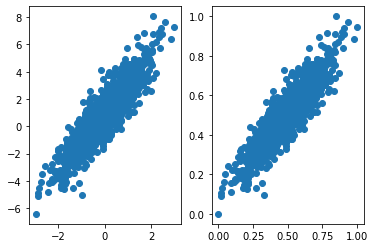

In [288]:
# 设置随机数种子
np.random.seed(24)   

# 扰动项取值为0.01
features, labels = arrayGenReg(delta=0.01)

# 绘制图像进行观察
plt.subplot(121)
plt.plot(features[:, 0], labels, 'o')
plt.subplot(122)
plt.plot(maxmin_norm(features[:, 0]), maxmin_norm(labels), 'o')

> 仿射变换指的是样本空间平移（加减某个数）和放缩（乘除某个数）的变换。0-1标准化过程中，平移就是减去每一列最小值，放缩就是除以某一列的极差。

&emsp;&emsp;最后，也是最重要的一点，那就是对于梯度下降算法来说，归一化能够提高收敛速度，例如下图所示，经过归一化处理之后的数据，在进行损失函数构造时损失函数的等高线图将更加均匀，此时梯度下降的收敛速度也将更快，具体理论理解详见下文论述，而在实际使用过程中，经过归一化的数据在梯度下降过程中往往收敛更快，这其实是相比消除量纲影响，归一化方法更加重要应用场景。

<img src="https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fupload-images.jianshu.io%2Fupload_images%2F2728907-3b3e13344c336cde.png&refer=http%3A%2F%2Fupload-images.jianshu.io&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1622730985&t=6f4b1f9096af46c395ffd77c18f38e0a" alt="74" style="zoom:30%;" />

> 在提高收敛速度方面，Z-Score效果要好于0-1标准化。

&emsp;&emsp;此处可以举例说明。还是以前两节的等高线图案例进行说明，尝试对比在进行数据归一化前后两组数据损失函数的等高线图及收敛轨迹图。

|数据特征|参数组|模型输出|数据标签|      
|:--:|:--:|:--:|:--:|   
|Whole weight(x)|$(w,b)$|$\hat y$|Rings(y)|    
|1|(w, b)|w+b|2|
|3|(w, b)|3w+b|4|

In [62]:
# 创建数据及进行深拷贝
x = np.array([[1, 1], [3, 1]])
x_norm = np.copy(x)

In [63]:
x_norm[:, :1] = z_score(x_norm[:, :1])
x_norm

array([[-1,  1],
       [ 1,  1]])

In [64]:
y = np.array([[2], [4]])
y

array([[2],
       [4]])

|数据特征|标准化数据|模型输出|数据标签|      
|:--:|:--:|:--:|:--:|   
|Whole weight(x)|$(w,b)$|$\hat y$|Rings(y)|    
|1|-1|-w+b|2|
|3|1|w+b|4|

则归一化前的SSE损失函数为：

$$SSE = (2-w-b)^2+(4-3w-b)$$

而归一化之后的损失函数为：

$$SSE = (2+w-b)^2 + (4-w-b)^2$$

对比两个损失函数的等高线图及梯度下降轨迹图：

In [65]:
np.random.seed(24)
w = np.random.randn(2, 1)
w_norm = np.copy(w)

In [66]:
w, w_res = w_cal_rec(x, w, y, gd_cal = lr_gd, lr = 0.1, itera_times = 100)
w_norm, w_res_norm = w_cal_rec(x_norm, w_norm, y, gd_cal = lr_gd, lr = 0.1, itera_times = 100)

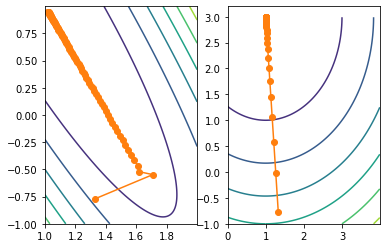

In [67]:
plt.subplot(121)
# 网格点坐标
x1, x2 = np.meshgrid(np.arange(1, 2, 0.001), np.arange(-1, 1, 0.001))
# 绘制等高线图
plt.contour(x1, x2, (2-x1-x2)**2+(4-3*x1-x2)**2)
# 参数点移动轨迹图
plt.plot(np.array(w_res)[:, 0], np.array(w_res)[:, 1], '-o', color='#ff7f0e')

plt.subplot(122)
# 网格点坐标
x1, x2 = np.meshgrid(np.arange(0, 4, 0.01), np.arange(-1, 3, 0.01))
# 绘制等高线图
plt.contour(x1, x2, (2+x1-x2)**2+(4-x1-x2)**2)
# 绘制参数点移动轨迹图
plt.plot(np.array(w_res_norm)[:, 0], np.array(w_res_norm)[:, 1], '-o', color='#ff7f0e')

&emsp;&emsp;能够看出经过归一化处理的之后的数据损失函数等高线更加均匀，收敛效率更高。

> 关于归一化能够让等高线更加均匀从而加快迭代收敛过程的理解：      
&emsp;&emsp;从理论角度出发，其实梯度下降过程每一步参数点移动的方向是能够让梯度最快速下降的方向，也就是图片上垂直于等高线的方向。但这种所谓的最快速的方向只在开始移动的一瞬间满足，由于梯度是连续变化的函数，因此当移动了一小步之后“最优方向”其实就可能发生了变化，但参数只能在下次移动时再改变方向，因此中间其实很长一段距离参数并不不一定是沿着最优方向在进行移动。这里需要注意，如果下一次移动的方向和上一次移动方向一致或者类似，那就说明这次移动过程中参数并没有偏离方向太多，反之则这次移动走了很多弯路。而当损失函数的等高线是均匀分布时，外圈的垂直线也就是内圈的垂直线，此时参数两次移动过程大概率最优方向一致，也就是说相同的移动能够更大程度降低损失函数值，而如果类似图1中的情况，内外圈分布不均匀，则参数两次迭代过程最优方向将发生偏移，也就是说明上一次迭代过程有很长一段距离没有沿着最优方向迭代，该次迭代只降低了有限的损失函数计算值。经次过程不断迭代，由于经过归一化的损失函数每次迭代效率都更高，因此相比其他损失函数，经过归一化的数据只需要更少次的迭代就能抵达最小值点，这也就是加快收敛速度的根本原因。

> 另外需要注意的是，收敛更快往往也意味着能够收敛至更靠近全局最小值的点。

### 4.Z-Score标准化算法评价及横向对比

&emsp;&emsp;从大类上来分，Z-Score的使用场景要远高于0-1标准化使用场景。当然这也并不是绝对的，要区分二者使用情景，我们首先需要进一步了解二者算法性能。

- 生成Zero-Centered Data

&emsp;&emsp;一般来说，由于Z-Score标准化生成数据的Zero-Centered特性，使得其在深度学习领域备受欢迎（是Batch Normalization的一种特殊情况）。而在机器学习领域对于标签同时存在正负值的回归类问题，使用Z-Score能够避免对标签进行归一化。

- 标准正态分布

&emsp;&emsp;由于该方法同时也是正态分布转换为标准正态分布的计算公式，因此如果原始数据满足正态分布，则经过Z-Score转化之后就能转化为标准正态分布，进而可以利用标准正态分布诸多统计性质。

- 保留极端值分布

&emsp;&emsp;还有一点非常实用的功能，就是相比0-1标准化，Z-Score标准化能够保留极端值的分布。例如有数据如下：

In [307]:
a = np.arange(8).reshape(4, 2)
a[1, 1] = 100
a

array([[  0,   1],
       [  2, 100],
       [  4,   5],
       [  6,   7]])

其中第二列的第二个值就是极端值，如果对a进行0-1标准化处理，则计算结果如下：

In [308]:
maxmin_norm(a)

array([[0.        , 0.        ],
       [0.33333333, 1.        ],
       [0.66666667, 0.04040404],
       [1.        , 0.06060606]])

我们会发现，由于极端值的存在，会将其他数值压缩在一个非常小的范围内。而如果此时我们采用Z-Score进行标准化，则计算结果如下：

In [309]:
z_score(a)

array([[-1.34164079, -0.65692457],
       [-0.4472136 ,  1.72970047],
       [ 0.4472136 , -0.56049527],
       [ 1.34164079, -0.51228063]])

我们发现，极端值仍然还是极端值（相对该列其他数值而言），此时我们即可采用极端值处理方法对其进行处理（删除或者盖帽）。

&emsp;&emsp;不过相比0-1标准化，Z-Score标准化问题也比较明显，那就是需要进行均值和方差的计算，而该过程将耗费更大的计算量。

## 二、梯度下降算法优化初阶

&emsp;&emsp;归一化和学习率调度，是梯度下降算法优化的基本方法。

### 1.数据归一化与梯度下降算法优化

&emsp;&emsp;接下来，我们讨论归一化与梯度下降之间的关系。此前我们通过简单例子观察了数据归一化对梯度下降的影响——即归一化能够改变损失函数形态，而这种改变将显著加快梯度下降的迭代收敛过程，直观判断是归一化之后的损失函数等高线图更加均匀。本小节我们将从梯度下降算法优化角度出发，讨论数据归一化和梯度下降之间的关系。

&emsp;&emsp;在机器学习模型优化体系中，构建损失函数和损失函数求解是模型优化的两大核心命题，通过损失函数的构建和求解，就能够找到模型最优参数。但对于很多复杂模型来说，损失函数构建和求解并非易事，而梯度下降作为损失函数求解的重要方法，如何优化梯度下降求解过程，使其能够“又快又好”的找到最小值点，就成了决定建模成败的核心因素。当然，从梯度下降到随机梯度下降再到小批量梯度下降，我们可以理解其为算法层面上的优化，但除此以外还有许多围绕优化梯度下降求解过程的算法和方法，例如本节介绍的归一化和学习率调度方法。

&emsp;&emsp;当然，优化方法的学习也需要遵循循序渐进的过程，本节我们仍然还是在线性回归损失函数、也就是凸函数上进行基本优化思路的介绍和基本优化方法的学习，围绕现线性回归的凸函数损失函数求解，其实是可以使用最小二乘法一步到位求出数值解的，但也正是因为其最优解明确存在，也就给了我们进行对照实验的基础。我们将利用梯度下降算法，在更加复杂的数据集上，探索如何使用优化方法，来逼近明确存在的全域最小值点，并在这个过程中深化对优化方法的理解，进而能够在后续更加复杂的损失函数上、甚至是非凸的损失函数上，凭借我们的理解和所掌握的工具，用好最小二乘法这把利器进行更快更好的最优参数的求解。

- 数据准备

&emsp;&emsp;此处我们选取Lesson 1中的鲍鱼数据集，并且采用其中相关性比较强的几列进行建模分析。数据集读取过程如下：

In [2]:
aba_data = pd.read_csv("abalone.csv")
aba_data

,Gender,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,-1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,-1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,1,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,1,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,-1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


&emsp;&emsp;其中，我们选取鲍鱼数据集中的Length（身体长度）和Diameter（身体宽度/直径）作为特征，Whole weight（体重）作为标签进行线性回归建模分析。

In [39]:
aba_value = aba_data.values
aba_value

array([[ 1.    ,  0.455 ,  0.365 , ...,  0.101 ,  0.15  , 15.    ],
       [ 1.    ,  0.35  ,  0.265 , ...,  0.0485,  0.07  ,  7.    ],
       [-1.    ,  0.53  ,  0.42  , ...,  0.1415,  0.21  ,  9.    ],
       ...,
       [ 1.    ,  0.6   ,  0.475 , ...,  0.2875,  0.308 ,  9.    ],
       [-1.    ,  0.625 ,  0.485 , ...,  0.261 ,  0.296 , 10.    ],
       [ 1.    ,  0.71  ,  0.555 , ...,  0.3765,  0.495 , 12.    ]])

In [40]:
features = aba_value[:, 1: 3]
features

array([[0.455, 0.365],
       [0.35 , 0.265],
       [0.53 , 0.42 ],
       ...,
       [0.6  , 0.475],
       [0.625, 0.485],
       [0.71 , 0.555]])

In [41]:
labels = aba_value[:, 4:5]
labels

array([[0.514 ],
       [0.2255],
       [0.677 ],
       ...,
       [1.176 ],
       [1.0945],
       [1.9485]])

然后分别准备一份原始数据与归一化后的数据。

In [42]:
features = np.concatenate((features, np.ones_like(labels)), axis=1)

# 深拷贝features用于归一化
features_norm = np.copy(features)

# 归一化处理
features_norm[:, :-1] = z_score(features_norm[:, :-1])

In [43]:
features

array([[0.455, 0.365, 1.   ],
       [0.35 , 0.265, 1.   ],
       [0.53 , 0.42 , 1.   ],
       ...,
       [0.6  , 0.475, 1.   ],
       [0.625, 0.485, 1.   ],
       [0.71 , 0.555, 1.   ]])

In [44]:
features_norm

array([[-0.57455813, -0.43214879,  1.        ],
       [-1.44898585, -1.439929  ,  1.        ],
       [ 0.05003309,  0.12213032,  1.        ],
       ...,
       [ 0.6329849 ,  0.67640943,  1.        ],
       [ 0.84118198,  0.77718745,  1.        ],
       [ 1.54905203,  1.48263359,  1.        ]])

In [45]:
features.shape

(4177, 3)

- 建模过程

&emsp;&emsp;首先是参数初始化与定义核心参数

In [46]:
# 设置初始参数
np.random.seed(24) 
n = features.shape[1]
w = np.random.randn(n, 1)
w_norm = np.copy(w)

# 记录迭代过程损失函数取值变化
Loss_l = []
Loss_norm_l = []

# 迭代次数/遍历数据集次数
epoch = 100

In [47]:
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

&emsp;&emsp;接下来，首先进行梯度下降算法尝试。

In [48]:
for i in range(epoch):
    w = w_cal(features, w, labels, lr_gd, lr = 0.02, itera_times = 1)
    Loss_l.append(MSELoss(features, w, labels))
    w_norm = w_cal(features_norm, w_norm, labels, lr_gd, lr = 0.02, itera_times = 1)
    Loss_norm_l.append(MSELoss(features_norm, w_norm, labels))

- 观察结果

&emsp;&emsp;和上一小节介绍的一样，我们可以通过损失函数变化曲线来观察梯度下降执行情况

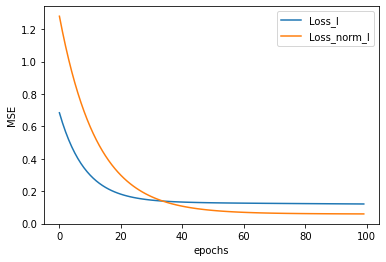

In [49]:
plt.plot(list(range(epoch)), np.array(Loss_l).flatten(), label='Loss_l')
plt.plot(list(range(epoch)), np.array(Loss_norm_l).flatten(), label='Loss_norm_l')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

我们发现，经过归一化后的数据集，从损失函数变化图像上来看，收敛速度更快（损失函数下降速度更快），且最终收敛到一个更优的结果。

In [50]:
Loss_l[-1]

array([[0.12121076]])

In [51]:
Loss_norm_l[-1]

array([[0.05988496]])

In [52]:
w

array([[ 1.71641833],
       [-0.46009876],
       [ 0.13633803]])

In [53]:
w_norm

array([[ 1.22387436],
       [-0.76710614],
       [ 0.80942526]])

> 这里需要注意，由于我们没有对标签进行归优化，因此两个迭代过程可以直接进行绝对数值的大小关系比较。

- 对比全域最小值点

&emsp;&emsp;当然，由于上述损失函数是凸函数，因此我们可以用最小二乘法直接求解全域最优解。这里需要注意，由于归一化只对数据进行平移和放缩而不改变数据分布规律，因此即使最小值点位置不同，但最终对应的对标签的预测结果应该保持一致，并且全域最小值点对应MSE数值也应该一致。

In [56]:
w1 = np.linalg.lstsq(features, labels, rcond=-1)[0]
w1

array([[ 1.87229017],
       [ 2.33724788],
       [-1.1056427 ]])

In [57]:
w2 = np.linalg.lstsq(features_norm, labels, rcond=-1)[0]
w2

array([[0.22482186],
       [0.2319204 ],
       [0.82874216]])

In [60]:
features.dot(w1)

array([[0.59934481],
       [0.16902955],
       [0.8683152 ],
       ...,
       [1.12792415],
       [1.19810388],
       [1.5208559 ]])

In [61]:
features_norm.dot(w2)

array([[0.59934481],
       [0.16902955],
       [0.8683152 ],
       ...,
       [1.12792415],
       [1.19810388],
       [1.5208559 ]])

In [62]:
MSELoss(features_norm, w2, labels)

array([[0.03318563]])

In [63]:
MSELoss(features, w1, labels)

array([[0.03318563]])

- 结论分析

&emsp;&emsp;通过上述计算结果，我们不难分析，其实在进行梯度下降计算过程中，在以0.02作为学习率进行迭代的过程中，两组模型都没有收敛到全域最小值点，也就是出现了类似如下情况：

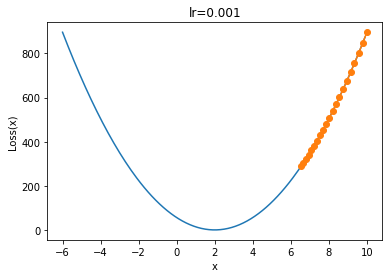

In [70]:
plt.title('lr=0.001')
show_trace(gd(lr=0.001))

&emsp;&emsp;但有趣的是，为何在相同学习率下，在归一化之后的数据集上进行梯度下降，却更加接近全域最小值点，这又是什么原因呢？回顾此前我们所讨论的归一化对损失函数的影响，从等高线图上来看是等高线变得更加均匀，但实际上是整个损失函数在不同区域对应梯度都更加均匀，从而在靠近最小值点附近的梯度也比归一化之前的损失函数梯度要大，也就是说，虽然学习率相同，但由于归一化之后最小值点附近梯度要更大，因此同样的迭代次，在归一化之后的损失函数上参数点将移动至更加靠近最小值地附近的点。也就类似如下情况：

In [79]:
def gd1(lr = 0.02, itera_times = 20, w = 10):
    """
    梯度下降计算函数
    :param lr: 学习率
    :param itera_times：迭代次数
    :param w：参数初始取值
    :return results：每一轮迭代的参数计算结果列表
    """                              
    results = [w]
    for i in range(itera_times):
        w -= lr * 28 * 2 * (w - 2)            # gd函数系数是28
        results.append(w)
    return results

In [82]:
def show_trace1(res):
    """
    梯度下降轨迹绘制函数
    """
    f_line = np.arange(-6, 10, 0.1)
    plt.plot(f_line, [28 * np.power(x-2, 2) for x in f_line])
    plt.plot(res, [28 * np.power(x-2, 2) for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('Loss(x)')

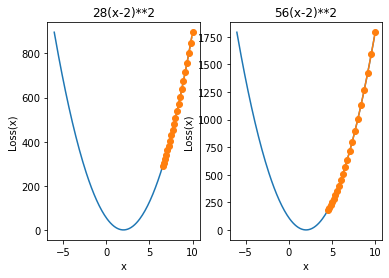

In [83]:
plt.subplot(121)
plt.title('28(x-2)**2')
show_trace(gd(lr=0.001))
plt.subplot(122)
plt.title('56(x-2)**2')
show_trace1(gd1(lr=0.001))

&emsp;&emsp;学习率相同，迭代次数相同，但经过归一化的损失函数更加陡峭，靠近最小值点附近梯度更大，因此最终收敛到一个更加靠近最小值点附近的点。而这个问题要如何解决，我们首先想到的是增加学习率，但问题是学习率增加多少才合适呢？试着增加10倍看下结果：

In [243]:
# 设置初始参数
np.random.seed(24) 
n = features.shape[1]
w = np.random.randn(n, 1)
w_norm = np.copy(w)

# 记录迭代过程损失函数取值变化
Loss_l = []
Loss_norm_l = []

# 迭代次数/遍历数据集次数
epoch = 100

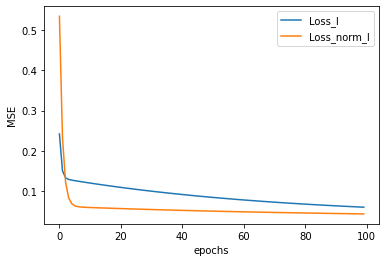

In [244]:
for i in range(epoch):
    w = w_cal(features, w, labels, lr_gd, lr = 0.2, itera_times = 1)
    Loss_l.append(MSELoss(features, w, labels))
    w_norm = w_cal(features_norm, w_norm, labels, lr_gd, lr = 0.2, itera_times = 1)
    Loss_norm_l.append(MSELoss(features_norm, w_norm, labels))
    
plt.plot(list(range(epoch)), np.array(Loss_l).flatten(), label='Loss_l')
plt.plot(list(range(epoch)), np.array(Loss_norm_l).flatten(), label='Loss_norm_l')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

In [245]:
Loss_l[-1]

array([[0.06004797]])

In [247]:
Loss_norm_l[-1]

array([[0.04334334]])

&emsp;&emsp;我们发现，在提高学习率之后，梯度下降效果略有提升，能够收敛到一个更加趋近于全域最小值的点，并且归一化之后的损失函数收敛速度明显更快。但以当前学习率，还是无法收敛止最小值点，此时我们可以不断尝试，直到“测出”最佳学习率为止。当然，在Scikit-Learn中其实也提供了这种类似枚举去找出最佳超参数取值的方法，但如果是面对超大规模数据集的建模，受到计算资源的限制，我们其实是无法反复建模来找到最优学习率的，此时就需要采用一种更加先进的计算流程来解决这个问题。

> 伴随数据集复杂程度提升，寻找最小值点过程将越来越复杂。并且哪怕是凸函数，很多情况也无法用最小二乘法一步到位求出最优解，仍然需要依靠梯度下降来求解，此时能够使用梯度下降的优化算法来帮助进行顺利求解，就变得至关重要。

### 2.学习率调度

- 基本概念

&emsp;&emsp;其实梯度下降优化的核心目标就是希望“更快更好”的找到最小值点，归一化是通过修改损失函数来达成这个目标，而所谓学习率调度，则是通过调整学习率来达到这个目标。值得注意的是，此时找到一个确定的最优学习率并不是目标，“更快更好”找到最小值点才是目标，因此我们完全可以考虑在迭代过程动态调整学习率。而所谓学习率调度，也并不是一个寻找最佳学习率的方法，而是一种伴随迭代进行、不断调整学习率的策略。      
&emsp;&emsp;学习率调度方法有很多种，目前流行的也达数十种之多，而其中一种最为通用的学习率调度方法是学习率衰减法，指的是在迭代开始时设置较大学习率，而伴随着迭代进行不断减小学习率。通过这样的学习率设置，能够让梯度下降收敛速度更快、效果更好。

- 实践过程

&emsp;&emsp;例如在上述例子中，我们不妨设置这样的减速衰减的一个学习调度策略，衰减过程比例由如下函数计算得出：

In [170]:
lr_lambda = lambda epoch: 0.95 ** epoch

In [171]:
lr_lambda(0)

1.0

In [172]:
lr_lambda(2)

0.9025

In [173]:
lr_l = []

In [174]:
for i in range(10):
    lr_l.append(lr_lambda(i))

In [175]:
lr_l

[1.0,
 0.95,
 0.9025,
 0.8573749999999999,
 0.8145062499999999,
 0.7737809374999998,
 0.7350918906249998,
 0.6983372960937497,
 0.6634204312890623,
 0.6302494097246091]

&emsp;&emsp;即假设初始学习率为0.5，则第一次迭代时实际学习率为0.5\*1，第二轮迭代时学习率为0.5\*0.95，以此类推。

&emsp;&emsp;据此，我们可以优化梯度下降迭代过程，此时我们对比恒定学习率和学习率衰减的两个梯度下降过程，并且都采用归一化后的数据集进行计算：

In [198]:
# 设置初始参数
np.random.seed(24) 
n = features.shape[1]
w = np.random.randn(n, 1)
w_lr = np.copy(w)

# 记录迭代过程损失函数取值变化
Loss_l = []
Loss_lr_l = []

# 迭代次数/遍历数据集次数
epoch = 20

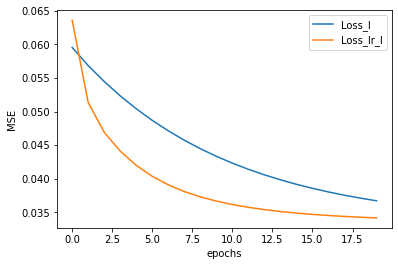

In [199]:
for i in range(epoch):
    w = w_cal(features_norm, w, labels, lr_gd, lr = 0.2, itera_times = 10)
    Loss_l.append(MSELoss(features_norm, w, labels))
    w_lr = w_cal(features_norm, w_lr, labels, lr_gd, lr = 0.5*lr_lambda(i), itera_times = 10)
    Loss_lr_l.append(MSELoss(features_norm, w_lr, labels))
    
plt.plot(list(range(epoch)), np.array(Loss_l).flatten(), label='Loss_l')
plt.plot(list(range(epoch)), np.array(Loss_lr_l).flatten(), label='Loss_lr_l')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

In [200]:
Loss_lr_l[-1]

array([[0.03416214]])

In [201]:
Loss_l[-1]

array([[0.03671235]])

&emsp;&emsp;这里有一点进行了微调，那就是我们实际上是令梯度下降计算过程中每迭代10次更新一次学习率，总共更新了20次学习率，即总共迭代了200次，最后10次更新时学习率为0.5\*lr_lambda(20)，即

In [204]:
0.5*lr_lambda(20)

0.17924296120427094

整体来看学习率变化区间横跨0.18-0.5之间，而最终上述学习率调度也确实起到了更好的效果。

- 算法评价

&emsp;&emsp;接下来，简单总结学习率调度的使用场景和注意事项。

&emsp;&emsp;首先，在很多海量数据处理场景下，学习率调度的重大价值在于能够提供对学习率超参数设置更大的容错空间。在很多情况下，搜索出一个最佳学习率取值进而设置恒定学习率进行梯度下降，难度会远高于设置一组学习率衰减的参数。并且有的时候，刚开始学习率设置过大其实也可以通过多轮迭代进行调整，其所消耗的算力也远低于反复训练模型寻找最佳恒定学习率。

&emsp;&emsp;其次，尽管上述例子我们是在梯度下降中使用学习率衰减这一调度策略，但实际上更为一般的情况是学习率调度和小批量梯度下降或者随机梯度下降来配合使用。一般来说梯度下降的使用场景在于小规模数据集且损失函数较为简单的情况，此时可利用梯度下降+枚举找到最佳学习率的策略进行模型训练，其相关操作的技术门槛相对较低（枚举法可借助Scikit-Learn的网格搜索）；而对于更大规模的数据集且损失函数情况更加复杂时，则需要考虑小批量梯度下降+学习率调度方法来进行梯度下降求解损失函数。

&emsp;&emsp;当然，除了学习率衰减外还有很多学习率调度策略，甚至有些学习率调度策略会间接性提高和降低学习率，来帮助梯度下降找到最小值点。更多学习率调度策略我们将在后续进阶内容中继续介绍。

### 3.小批量梯度下降与迭代收敛速度

&emsp;&emsp;小批量梯度下降不仅可以帮助损失函数跨越局部最小值点，同时也能加快梯度下降的收敛速度。例如以0.02作为学习率、batch_size为50的情况下，测试梯度下降收敛过程：

In [218]:
# 设置初始参数
np.random.seed(24) 
n = features.shape[1]
w = np.random.randn(n, 1)
w_norm = np.copy(w)

# 记录迭代过程损失函数取值变化
Loss_l = []
Loss_norm_l = []

# 迭代次数/遍历数据集次数
epoch = 50

In [142]:
np.random.seed(24)  
w = np.random.randn(3, 1)
sgd_cal(Xtrain, w, ytrain, lr_gd, batch_size=1, epoch=3000, lr=0.02)

array([[ 0.76959334],
       [-0.29175077],
       [-0.17624047]])

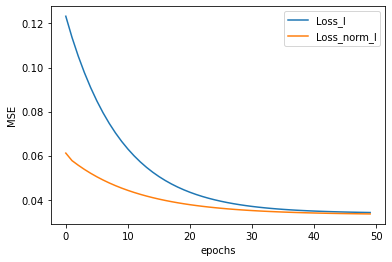

In [219]:
# 执行迭代计算
for i in range(epoch):
    w = sgd_cal(features, w, labels, lr_gd, batch_size=50, epoch=1, lr=0.02)
    Loss_l.append(MSELoss(features, w, labels))
    w_norm = sgd_cal(features_norm, w_norm, labels, lr_gd, batch_size=50, epoch=1, lr=0.02)
    Loss_norm_l.append(MSELoss(features_norm, w_norm, labels))

# 观察计算结果
plt.plot(list(range(epoch)), np.array(Loss_l).flatten(), label='Loss_l')
plt.plot(list(range(epoch)), np.array(Loss_norm_l).flatten(), label='Loss_norm_l')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

In [220]:
Loss_l[-1]

array([[0.03418411]])

&emsp;&emsp;在遍历50次数据集的情况下就已经能够基本逼近全域最优解，这说明局部规律的不一致性其实也将有助于提升模型收敛效率。同时我们也能发现数据归一化也能够有效提升小批量梯度下降的收敛速度。

### 4.梯度下降组合优化策略

&emsp;&emsp;当然，无论是数据归一化、学习率调度还是采用小批量梯度下降，这些方法并不互斥，我们完全可以组合进行使用。

In [250]:
# 设置初始参数
np.random.seed(24) 
n = features.shape[1]
w = np.random.randn(n, 1)
w_opt = np.copy(w)

# 记录迭代过程损失函数取值变化
Loss_l = []
Loss_opt_l = []

# 迭代次数/遍历数据集次数
epoch = 100

In [251]:
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

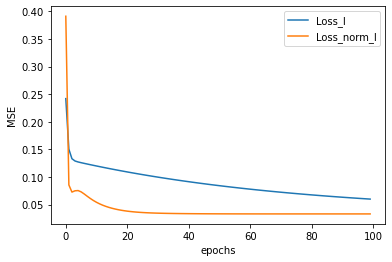

In [252]:
# 执行迭代计算
for i in range(epoch):
    w = w_cal(features, w, labels, lr_gd, lr = 0.2, itera_times = 1)
    Loss_l.append(MSELoss(features, w, labels))
    w_opt = sgd_cal(features_norm, w_opt, labels, lr_gd, batch_size=50, epoch=1, lr=0.5*lr_lambda(i))
    Loss_opt_l.append(MSELoss(features_norm, w_opt, labels))

# 观察计算结果
plt.plot(list(range(epoch)), np.array(Loss_l).flatten(), label='Loss_l')
plt.plot(list(range(epoch)), np.array(Loss_opt_l).flatten(), label='Loss_norm_l')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

In [253]:
Loss_opt_l[-1]

array([[0.03318614]])

In [254]:
Loss_l[-1]

array([[0.06004797]])